In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pydicom
import numpy as np
import xml.etree.ElementTree as ET
from skimage.draw import polygon
from skimage.transform import resize
import cv2
from tqdm import tqdm
import tensorflow as tf
import tensorflow as tf
import numpy as np
from PIL import Image

In [329]:
# Force eager execution (slower, but works with tf.py_function)
tf.config.run_functions_eagerly(True)


In [330]:
cwd = os.getcwd()
print("Current working directory:", cwd)


Current working directory: c:\Users\iyedm\OneDrive\Desktop\AI Prep


In [331]:
def load_image(image_path):
    image_path = image_path.numpy().decode("utf-8")
    img = Image.open(image_path).convert("RGB")
    img = np.array(img, dtype=np.float32)
    return img

def load_mask(mask_path):
    mask_path = mask_path.numpy().decode("utf-8")
    mask = Image.open(mask_path).convert("RGB")
    mask = np.array(mask, dtype=np.uint8)
    mask = np.max(mask, axis=-1, keepdims=True)  # combine channels
    mask = (mask > 0).astype(np.float32)          # binary mask
    return mask

def process_path(image_path, mask_path, fov_path):
    img = tf.py_function(func=load_image, inp=[image_path], Tout=tf.float32)
    mask = tf.py_function(func=load_mask, inp=[mask_path], Tout=tf.float32)
    fov = tf.py_function(func=load_mask, inp=[fov_path], Tout=tf.float32)
    
    img.set_shape([None, None, 3])
    mask.set_shape([None, None, 1])
    fov.set_shape([None, None, 1])
    
    mask = tf.cast(mask, tf.float32)
    fov = tf.cast(fov, tf.float32)
    masked_vein = mask * fov
    
    return img, masked_vein

def preprocess(image, masked_vein):
    input_image = tf.image.resize(image, (224, 224))  # bilinear for images
    input_masked_vein = tf.image.resize(masked_vein, (224, 224), method='nearest')
    
    input_image /= 255.0
    input_masked_vein /= 1.0  # already 0/1
    
    return input_image, input_masked_vein


(584, 565, 1)


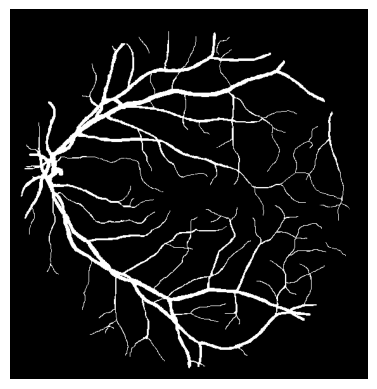

In [332]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load mask
mask = Image.open("DRIVE/training/1st_manual/21_manual1.gif").convert("RGB")
mask = np.array(mask, dtype=np.uint8)
mask = np.max(mask, axis=-1, keepdims=True)  # combine channels
mask = (mask > 0).astype(np.float32)         # binary mask
print(mask.shape)
# Squeeze to 2D
mask_2d = np.squeeze(mask, axis=-1)

# Display
plt.imshow(mask_2d, cmap='gray')
plt.axis('off')
plt.show()


(584, 565, 1)


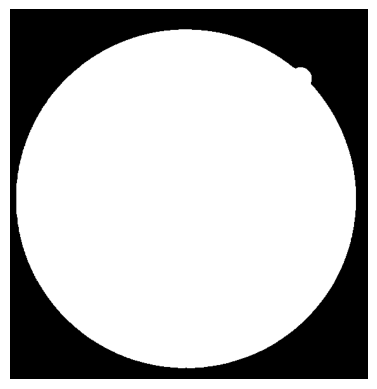

In [333]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load mask
fov = Image.open("DRIVE/training/mask/21_training_mask.gif").convert("RGB")
fov = np.array(fov, dtype=np.uint8)
fov = np.max(fov, axis=-1, keepdims=True)  # combine channels
fov = (fov > 0).astype(np.float32)         # binary mask
print(fov.shape)
# Squeeze to 2D
fov_2d = np.squeeze(fov, axis=-1)

# Display
plt.imshow(fov_2d, cmap='gray')
plt.axis('off')
plt.show()


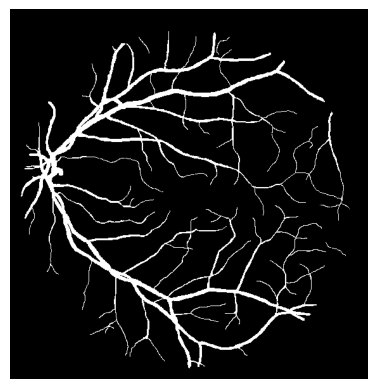

In [334]:
masked_vein = fov_2d * mask_2d

# Display
plt.imshow(masked_vein, cmap='gray')
plt.axis('off')
plt.show()

In [335]:
def DRIVE_preprocessing_pipeline(split):
    if split =="train":
        path = "DRIVE/training"
    else:
        path = "DRIVE/test"
    image_path = os.path.join(path, './images/')
    mask_path = os.path.join(path, './1st_manual/')
    fov_path = os.path.join(path, './mask/') 
    image_list = os.listdir(image_path)
    mask_list = os.listdir(mask_path)
    fov_list = os.listdir(fov_path)
    image_list = [image_path+i for i in image_list]
    mask_list = [mask_path+i for i in mask_list]    
    fov_list = [fov_path+i for i in fov_list]

    image_filenames = tf.constant(image_list)
    masks_filenames = tf.constant(mask_list)
    fov_filenames = tf.constant(fov_list)
    dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames, fov_filenames ))
    image_ds = dataset.map(process_path)
    processed_image_ds = image_ds.map(preprocess)
    return image_ds, processed_image_ds

In [336]:
image_ds, processed_image_ds = DRIVE_preprocessing_pipeline(split="train")

total_images = 20
test_size = 4
train_size = total_images - test_size


# Use `take` for test, `skip` for train
test_ds = processed_image_ds.take(test_size)
train_ds = processed_image_ds.skip(test_size)



c:\Users\iyedm\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [337]:
for img, mask in processed_image_ds.take(1):
    print("Image shape:", img.shape)
    print("Mask shape:", mask.shape)


Image shape: (224, 224, 3)
Mask shape: (224, 224, 1)


### Unet Model

In [338]:
from tensorflow.keras.layers import Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input

In [339]:
# UNQ_C1
# GRADED FUNCTION: conv_block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    ### END CODE HERE
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = Dropout(dropout_prob)(conv)
         ### END CODE HERE
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D(2,strides=2)(conv)
        ### END CODE HERE
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [340]:
# UNQ_C2
# GRADED FUNCTION: upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    ### START CODE HERE
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,# Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    ### END CODE HERE
    
    return conv

In [341]:
# UNQ_C3
# GRADED FUNCTION: unet_model
def unet_model(input_size=(224, 224, 3), n_filters=32, n_classes=1):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    # Include a dropout of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here,at each step, use half the number of filters of the previous block 
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)
    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [342]:
img_height, img_width, num_channels = (224,224, 3)


unet = unet_model((img_height, img_width, num_channels))

### Loss function

In [343]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [344]:
BATCH_SIZE = 1
BUFFER_SIZE = 500
EPOCHS = 10
# Properly batch and shuffle
train_dataset = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset  = test_ds.batch(1).prefetch(tf.data.AUTOTUNE)


In [345]:
model_history = unet.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 494ms/step - accuracy: 0.8082 - loss: 0.7897 - val_accuracy: 0.9132 - val_loss: 0.4960
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 490ms/step - accuracy: 0.9144 - loss: 0.4431 - val_accuracy: 0.9132 - val_loss: 0.3178
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 517ms/step - accuracy: 0.9133 - loss: 0.3074 - val_accuracy: 0.9132 - val_loss: 0.2672
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9152 - loss: 0.2666

KeyboardInterrupt: 

In [ ]:
def display(display_list):
    plt.figure(figsize=(40, 40))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if display_list[i].ndim == 2:  # grayscale mask
            plt.imshow(display_list[i], cmap='gray')
        else:  # RGB image
            plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()


In [ ]:
def create_mask(pred_mask):
    """
    Convert the model prediction to a binary mask
    """
    # If the model outputs a single channel with logits or probabilities
    # Threshold at 0.5 
    pred_mask = tf.sigmoid(pred_mask)  # shape still (1,96,128,1)
    mask = tf.cast(pred_mask > 0.2, tf.float32)
    return mask


In [ ]:
def show_predictions(dataset, num=1):
    for img_batch, mask_batch in dataset.take(num):
        pred_mask = unet.predict(img_batch)  # already batched
        print(pred_mask[0].shape)
        display([img_batch[0], mask_batch[0], create_mask(pred_mask[0])])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
(224, 224, 1)


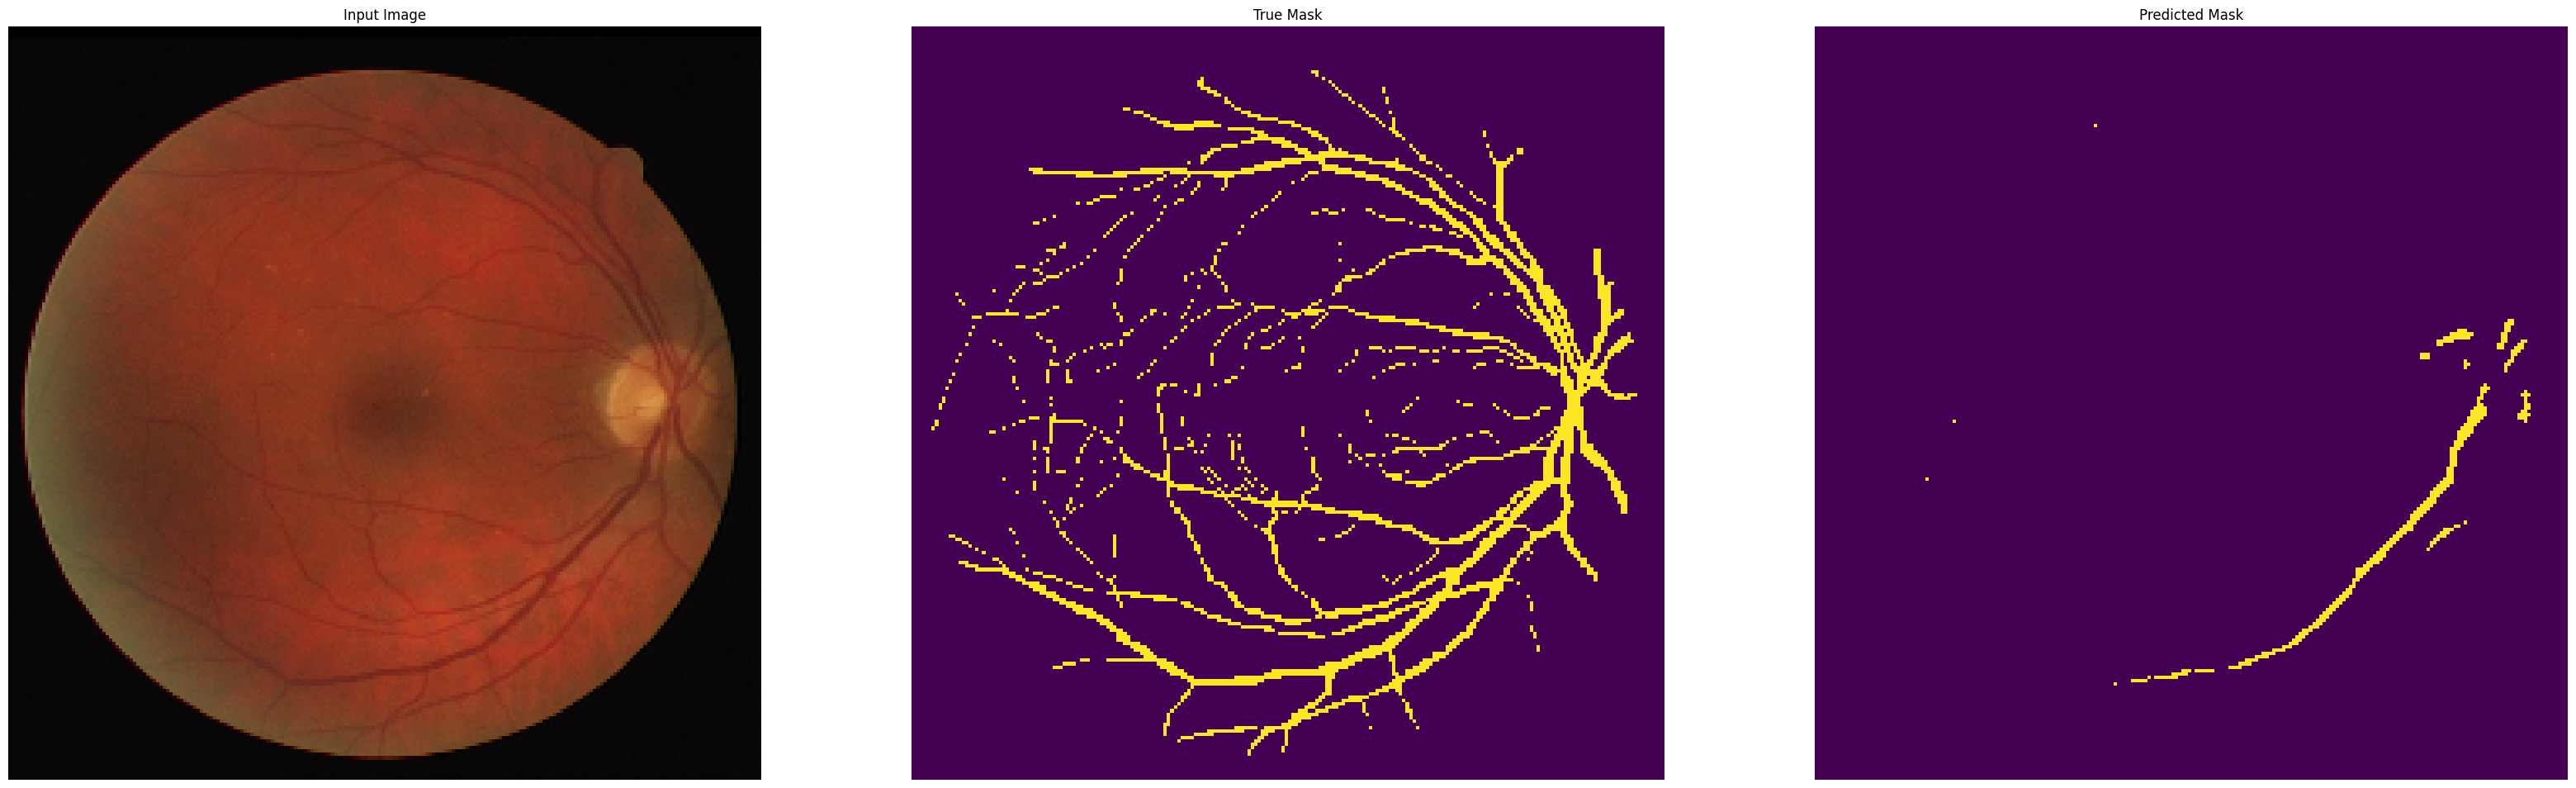

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
(224, 224, 1)


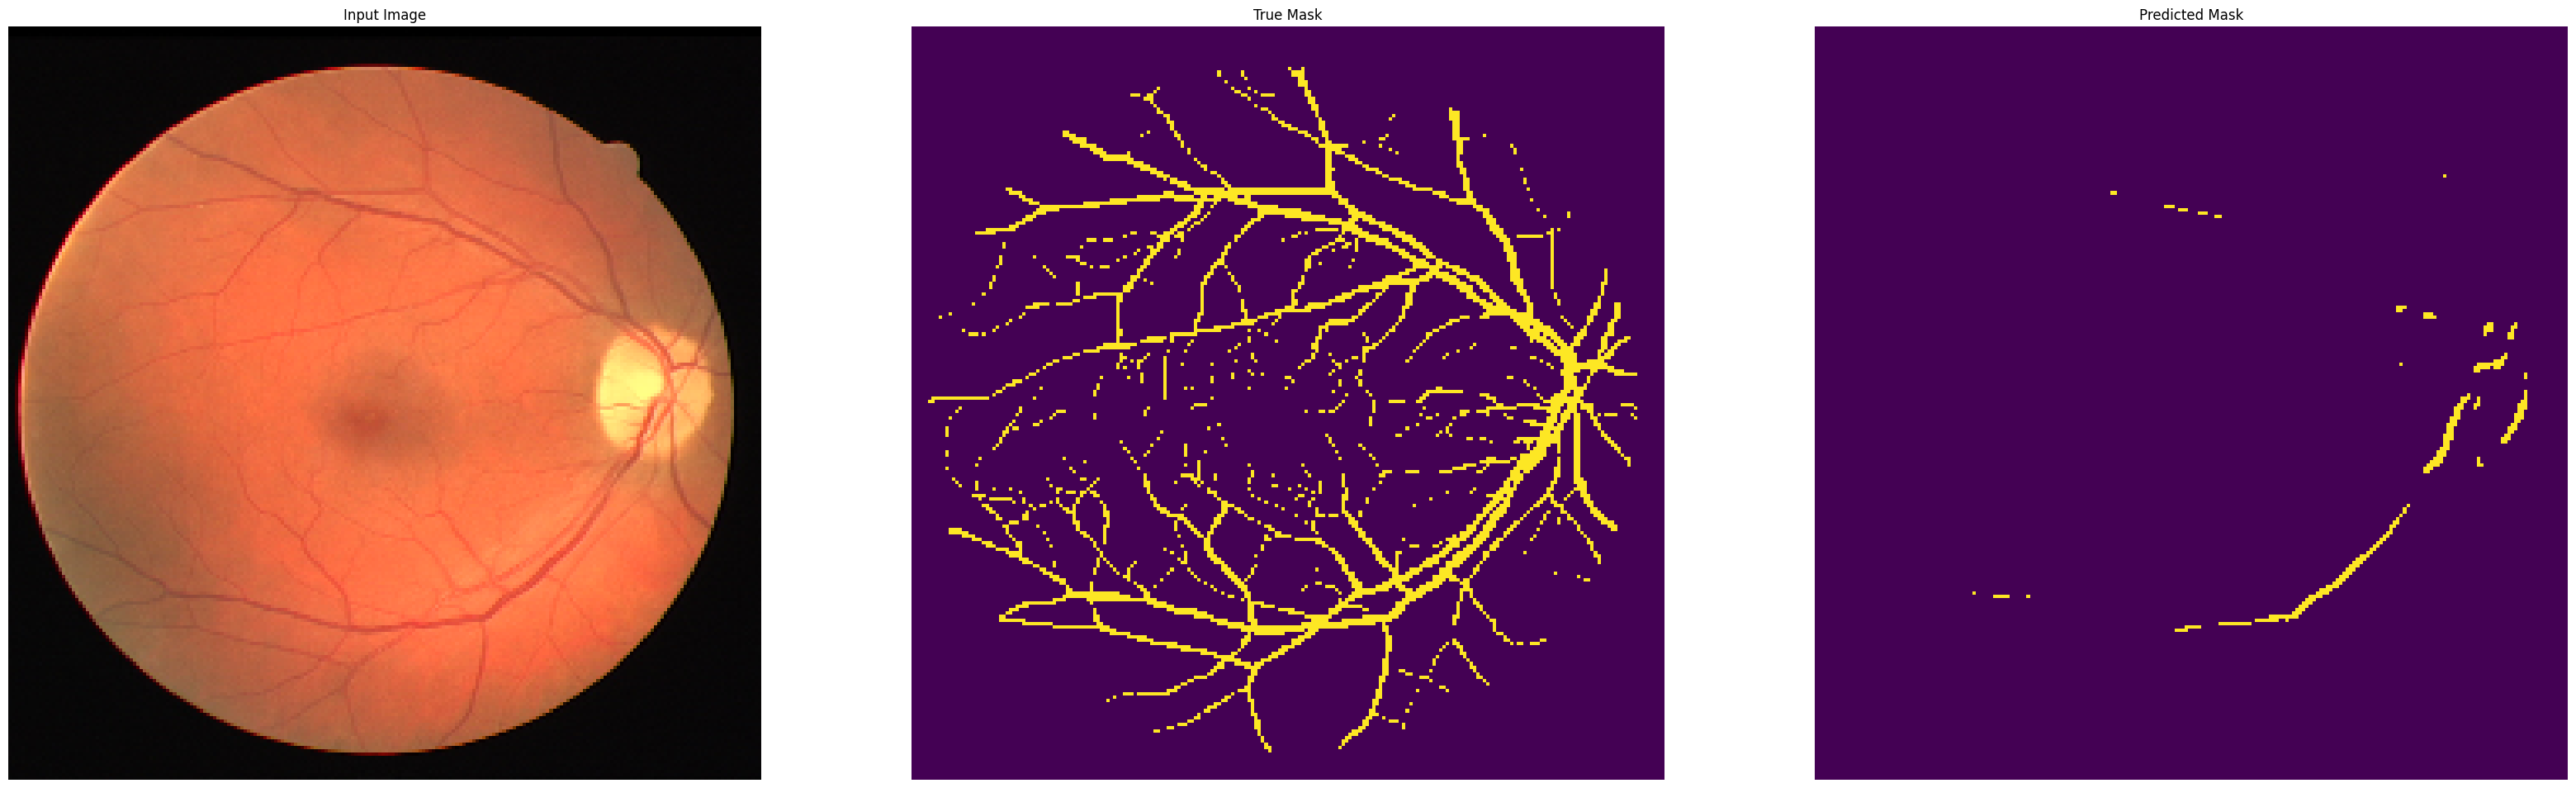

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
(224, 224, 1)


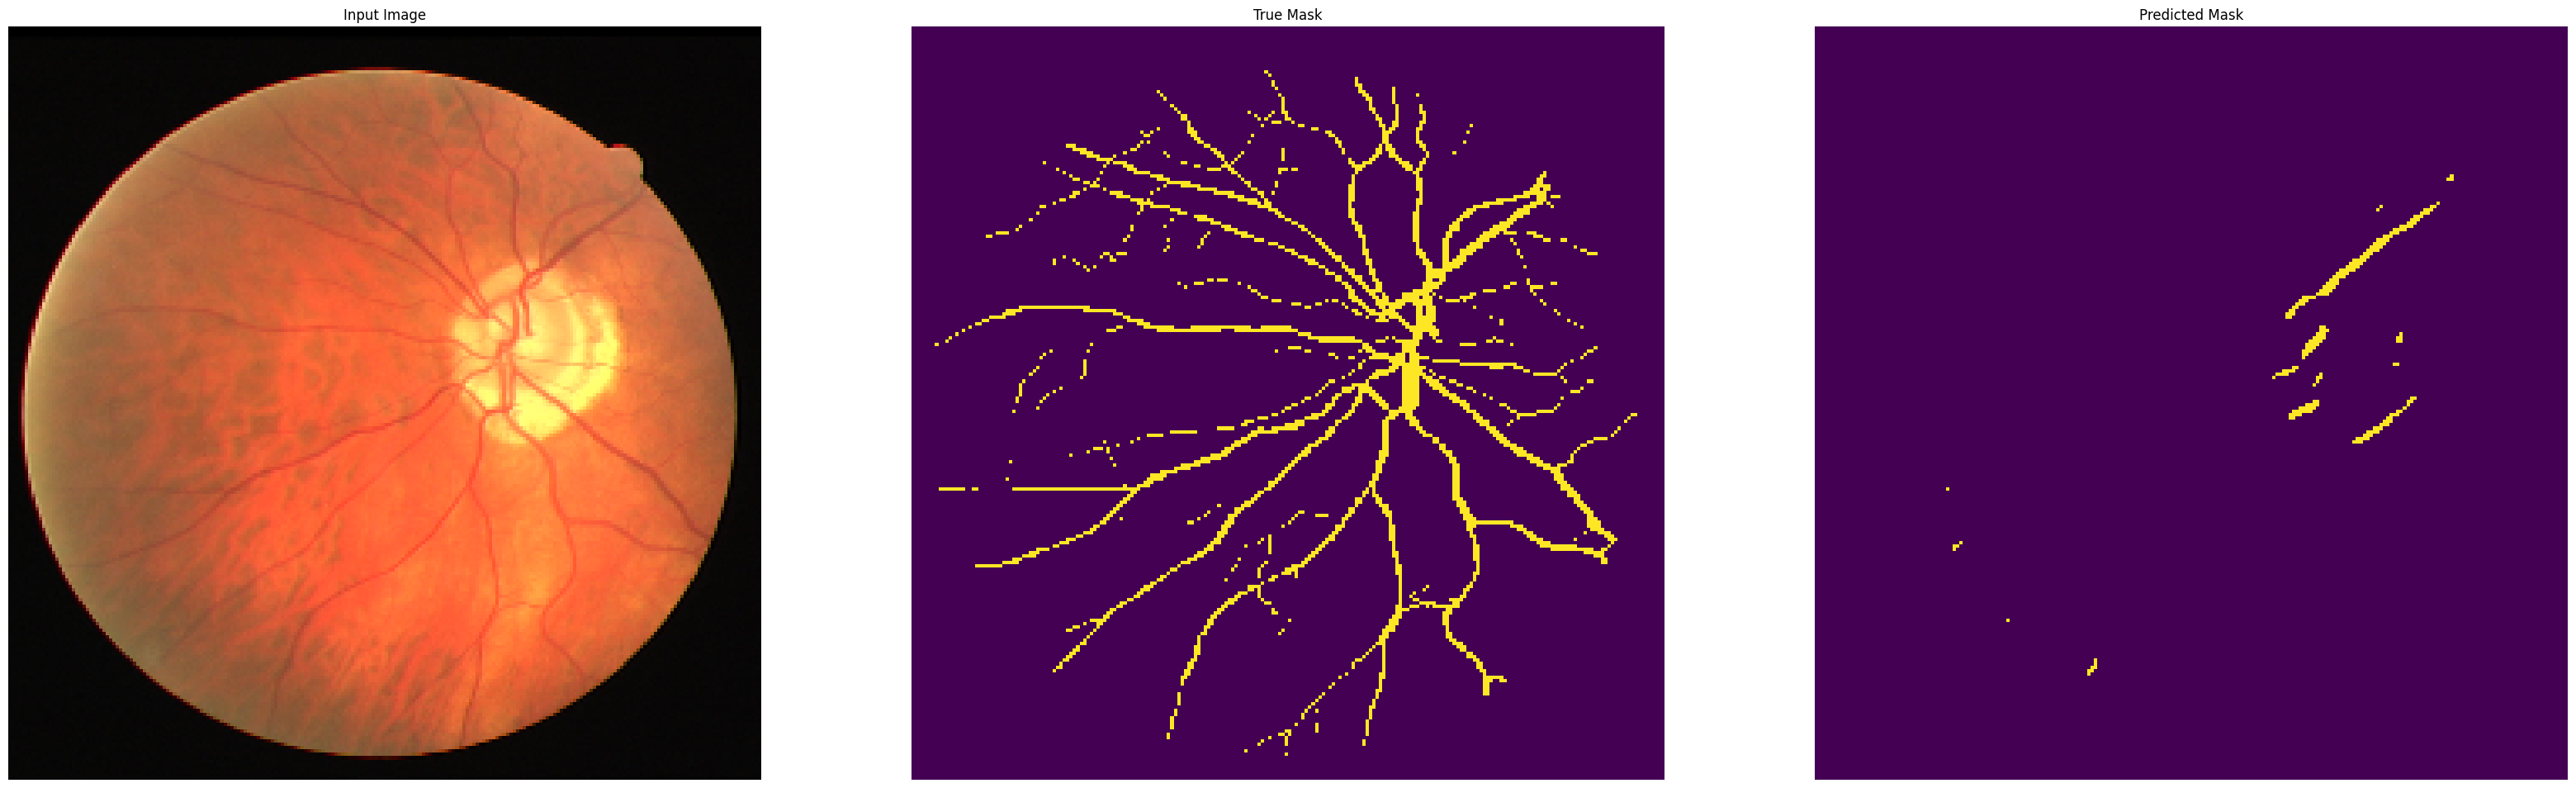

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
(224, 224, 1)


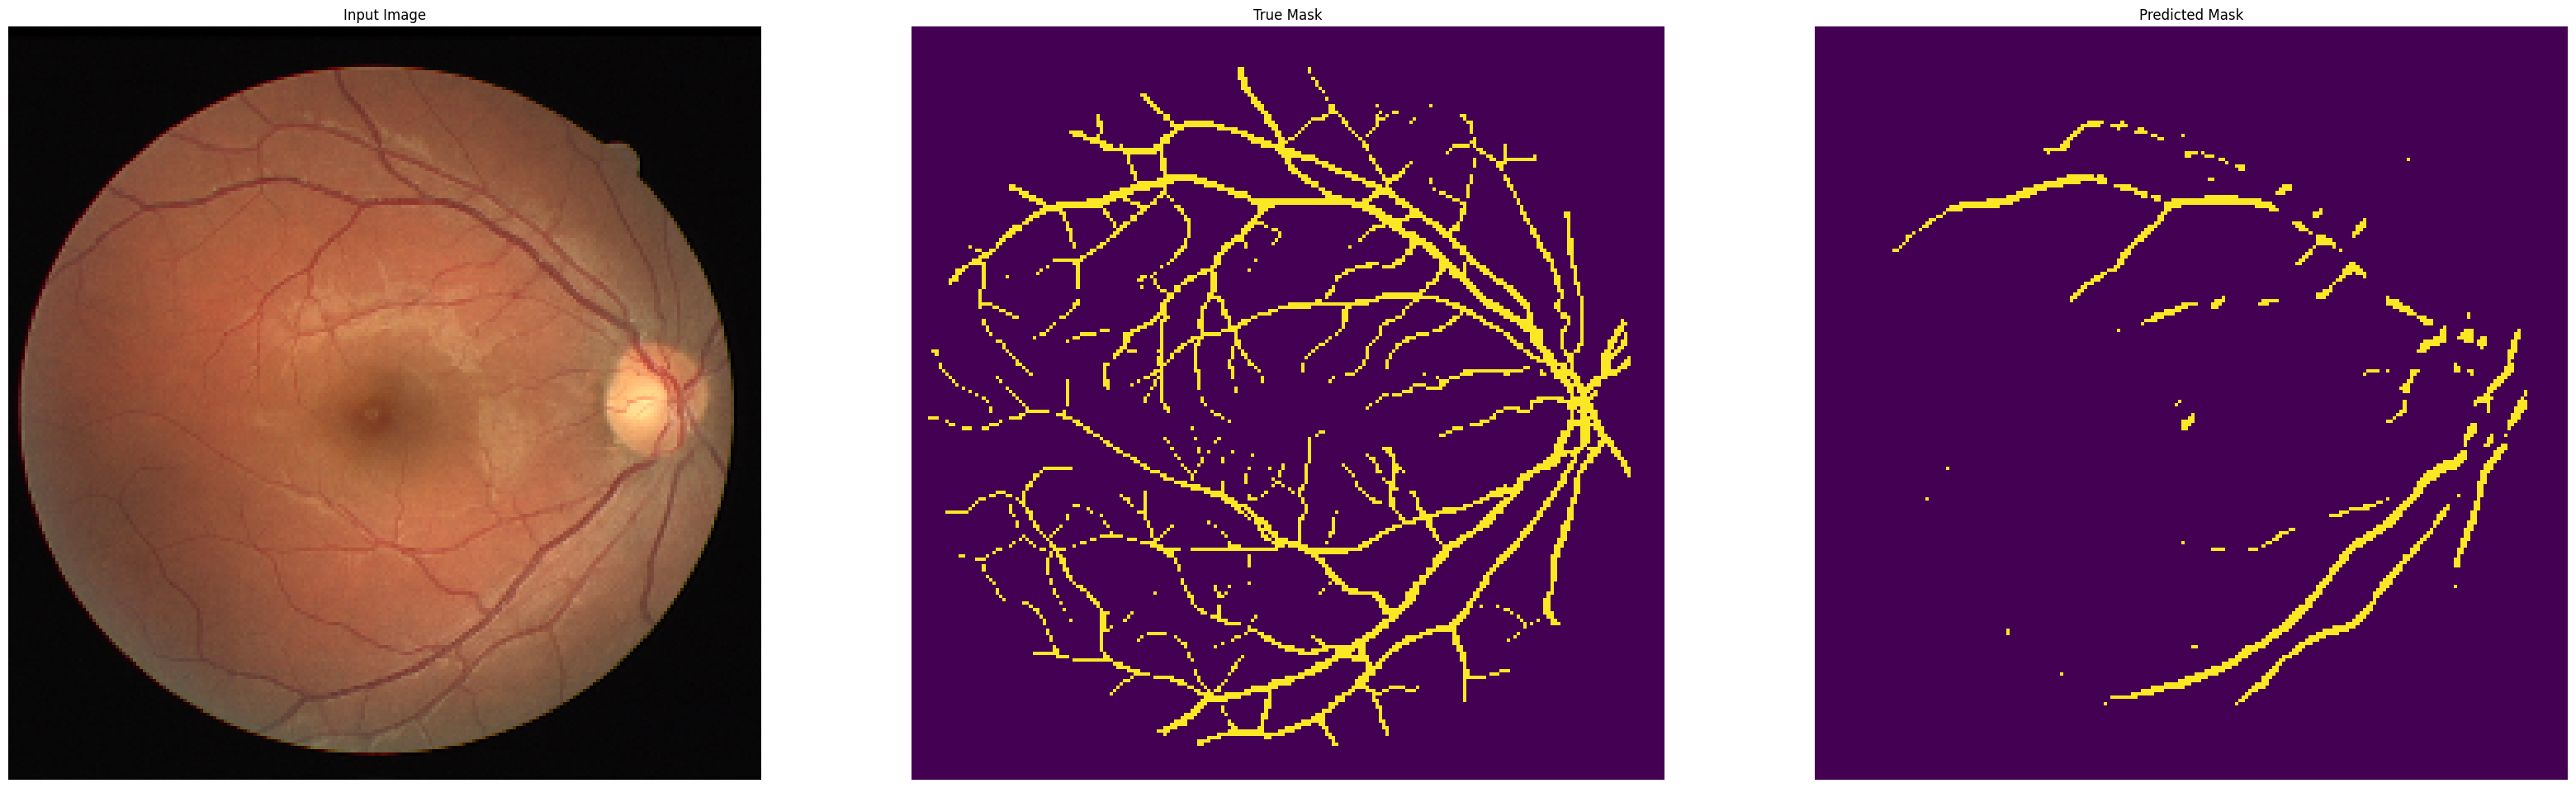

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
(224, 224, 1)


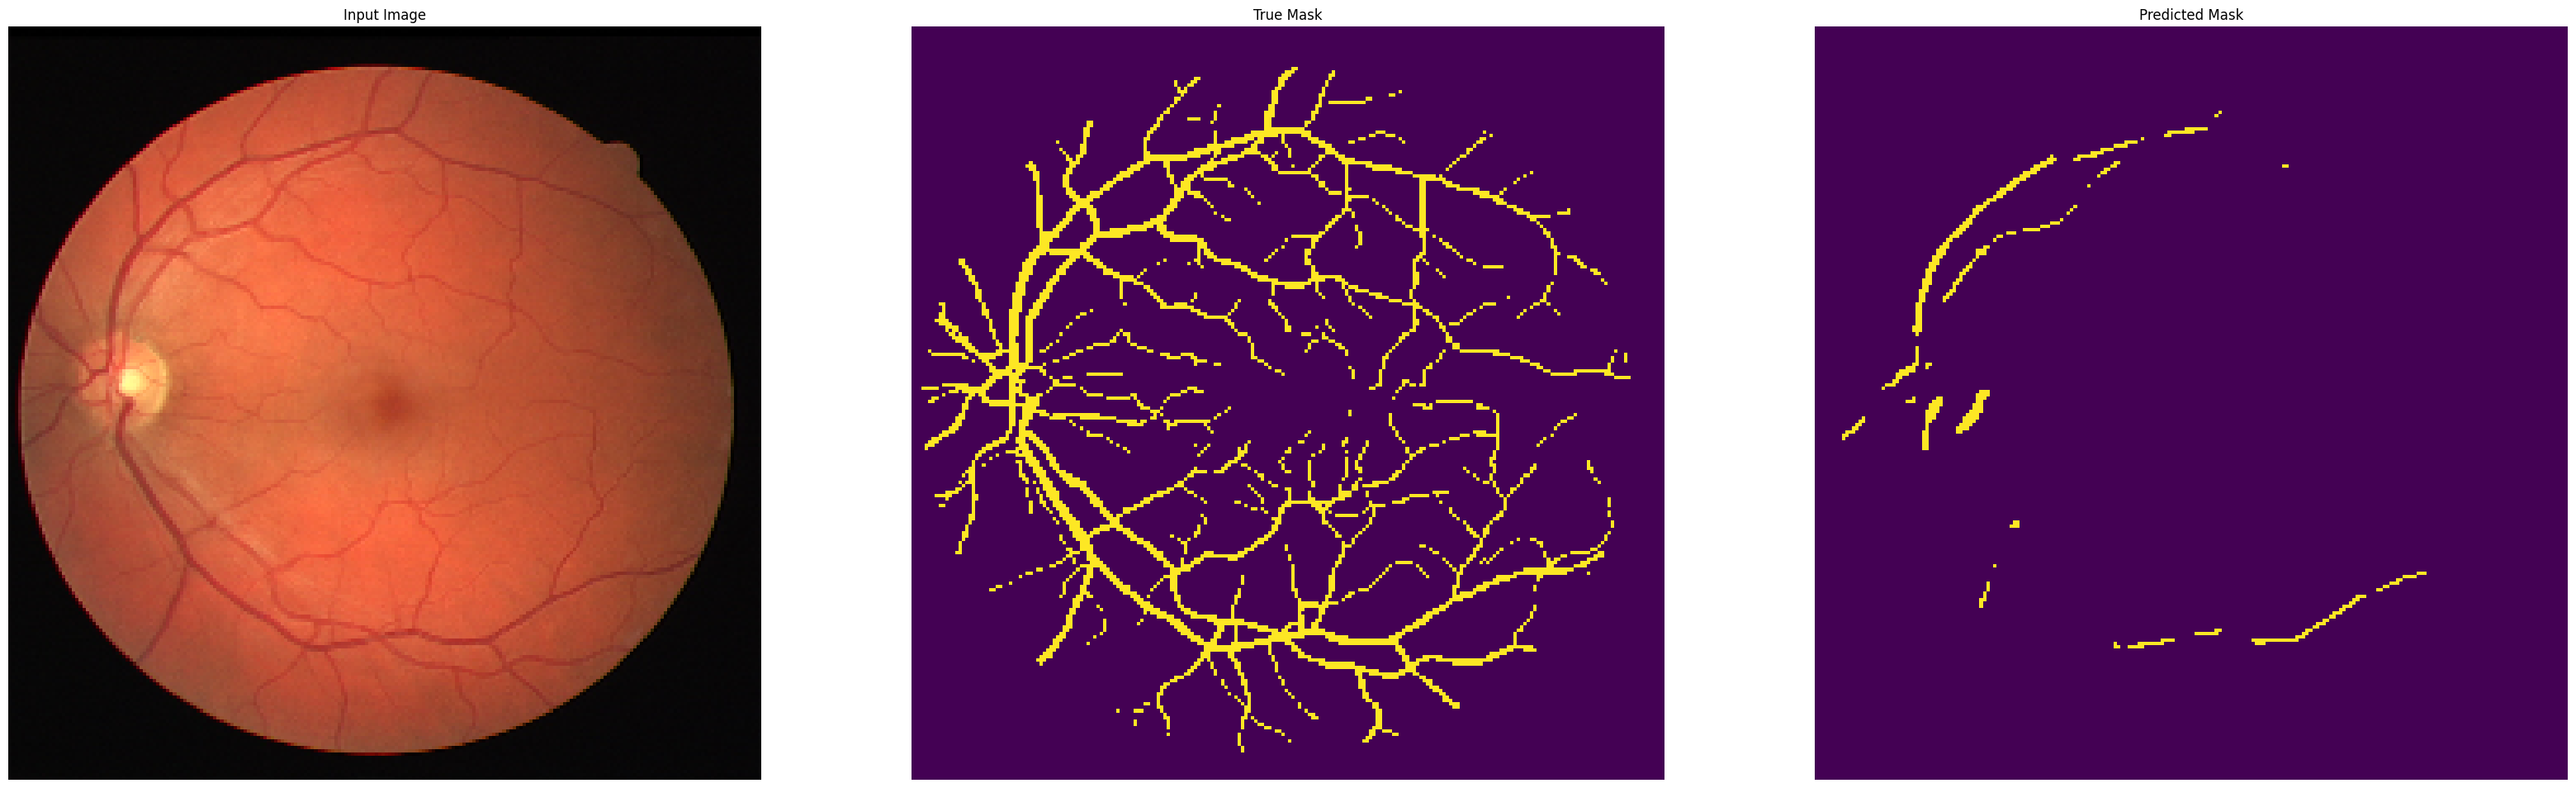

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
(224, 224, 1)


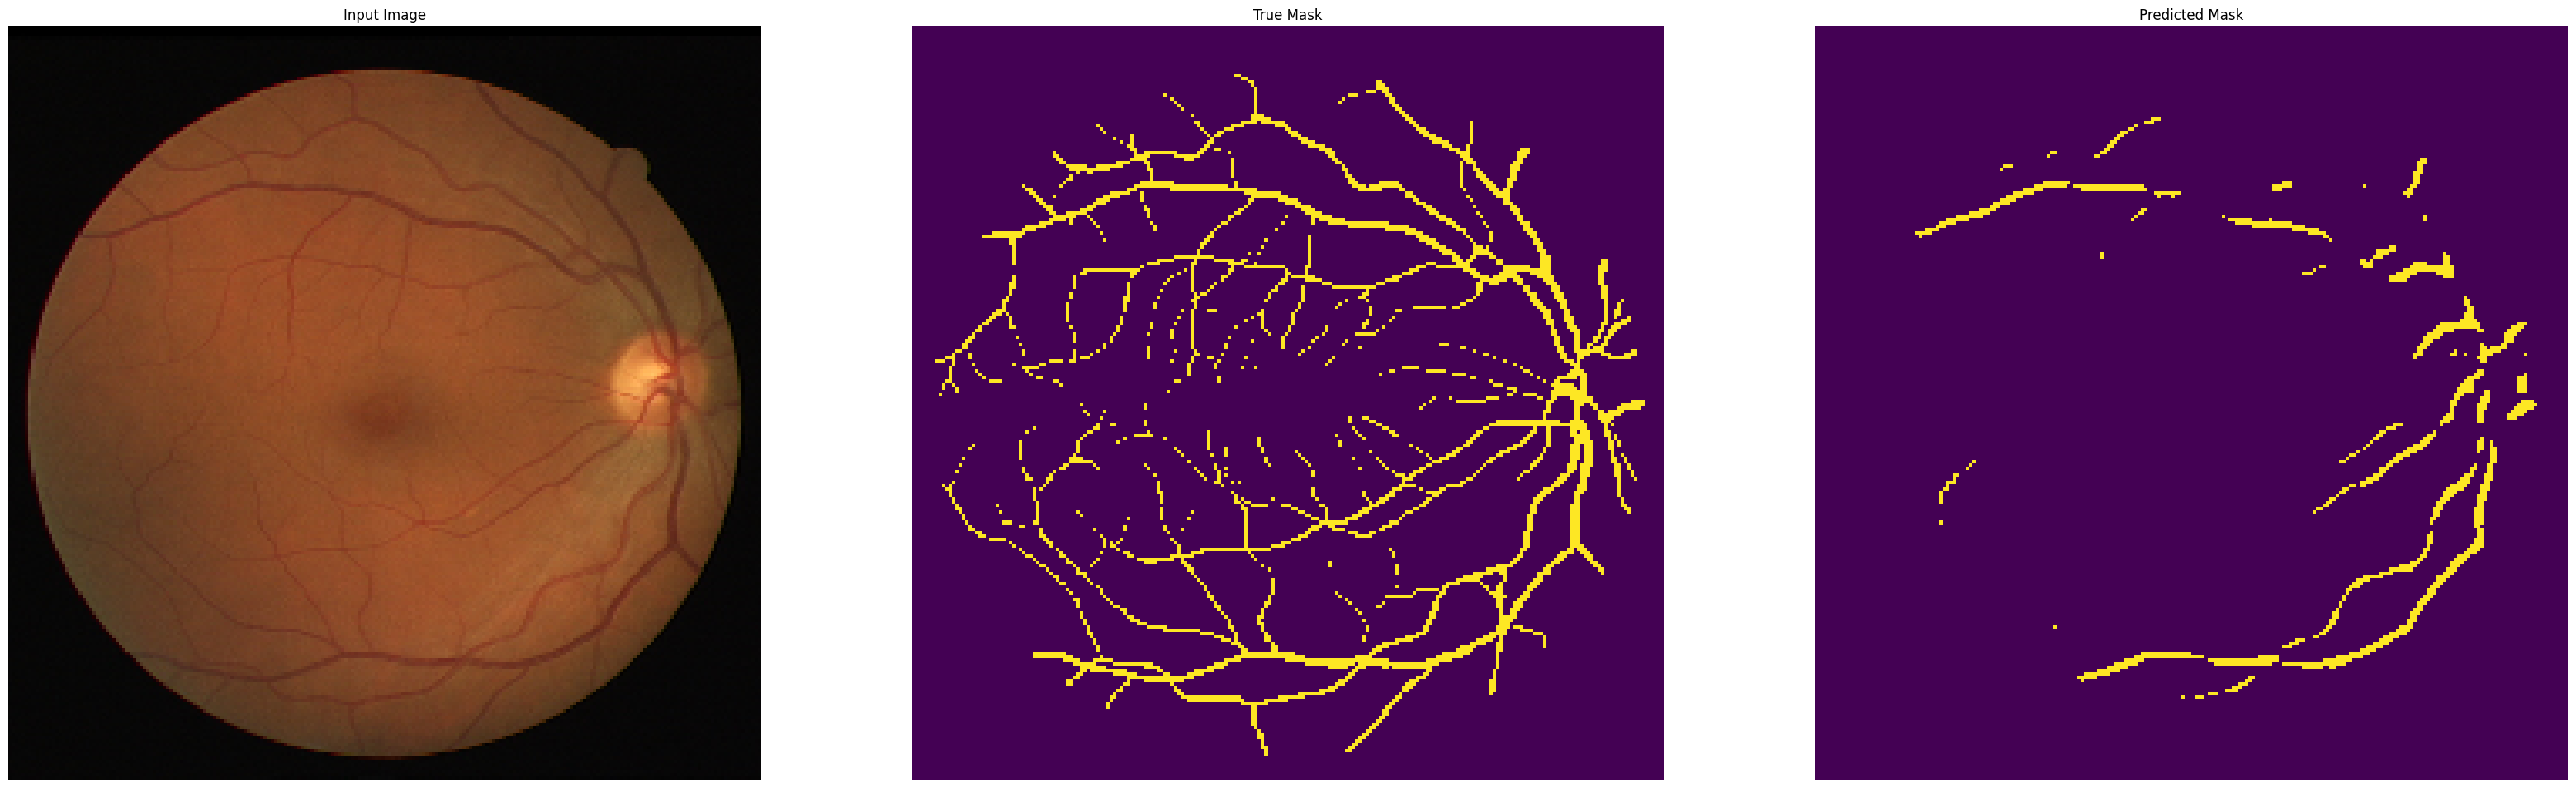

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
(224, 224, 1)


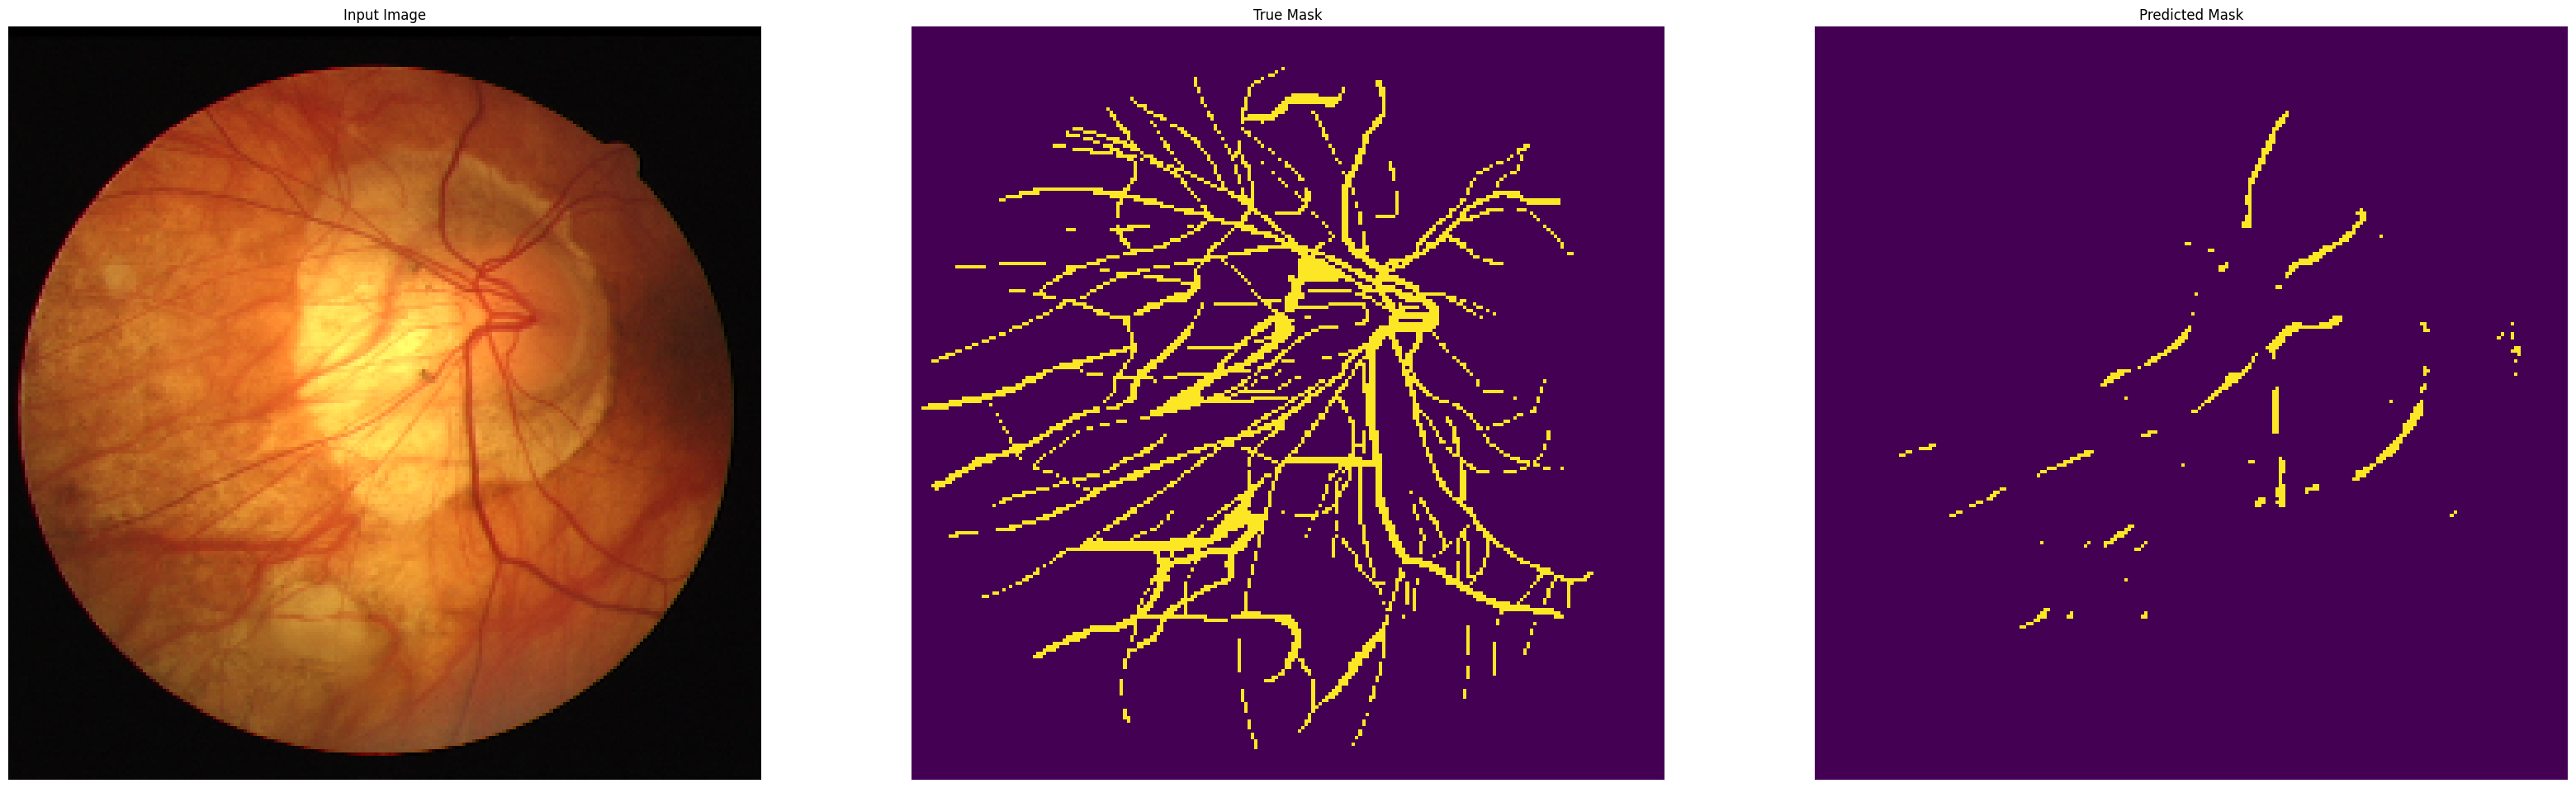

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
(224, 224, 1)


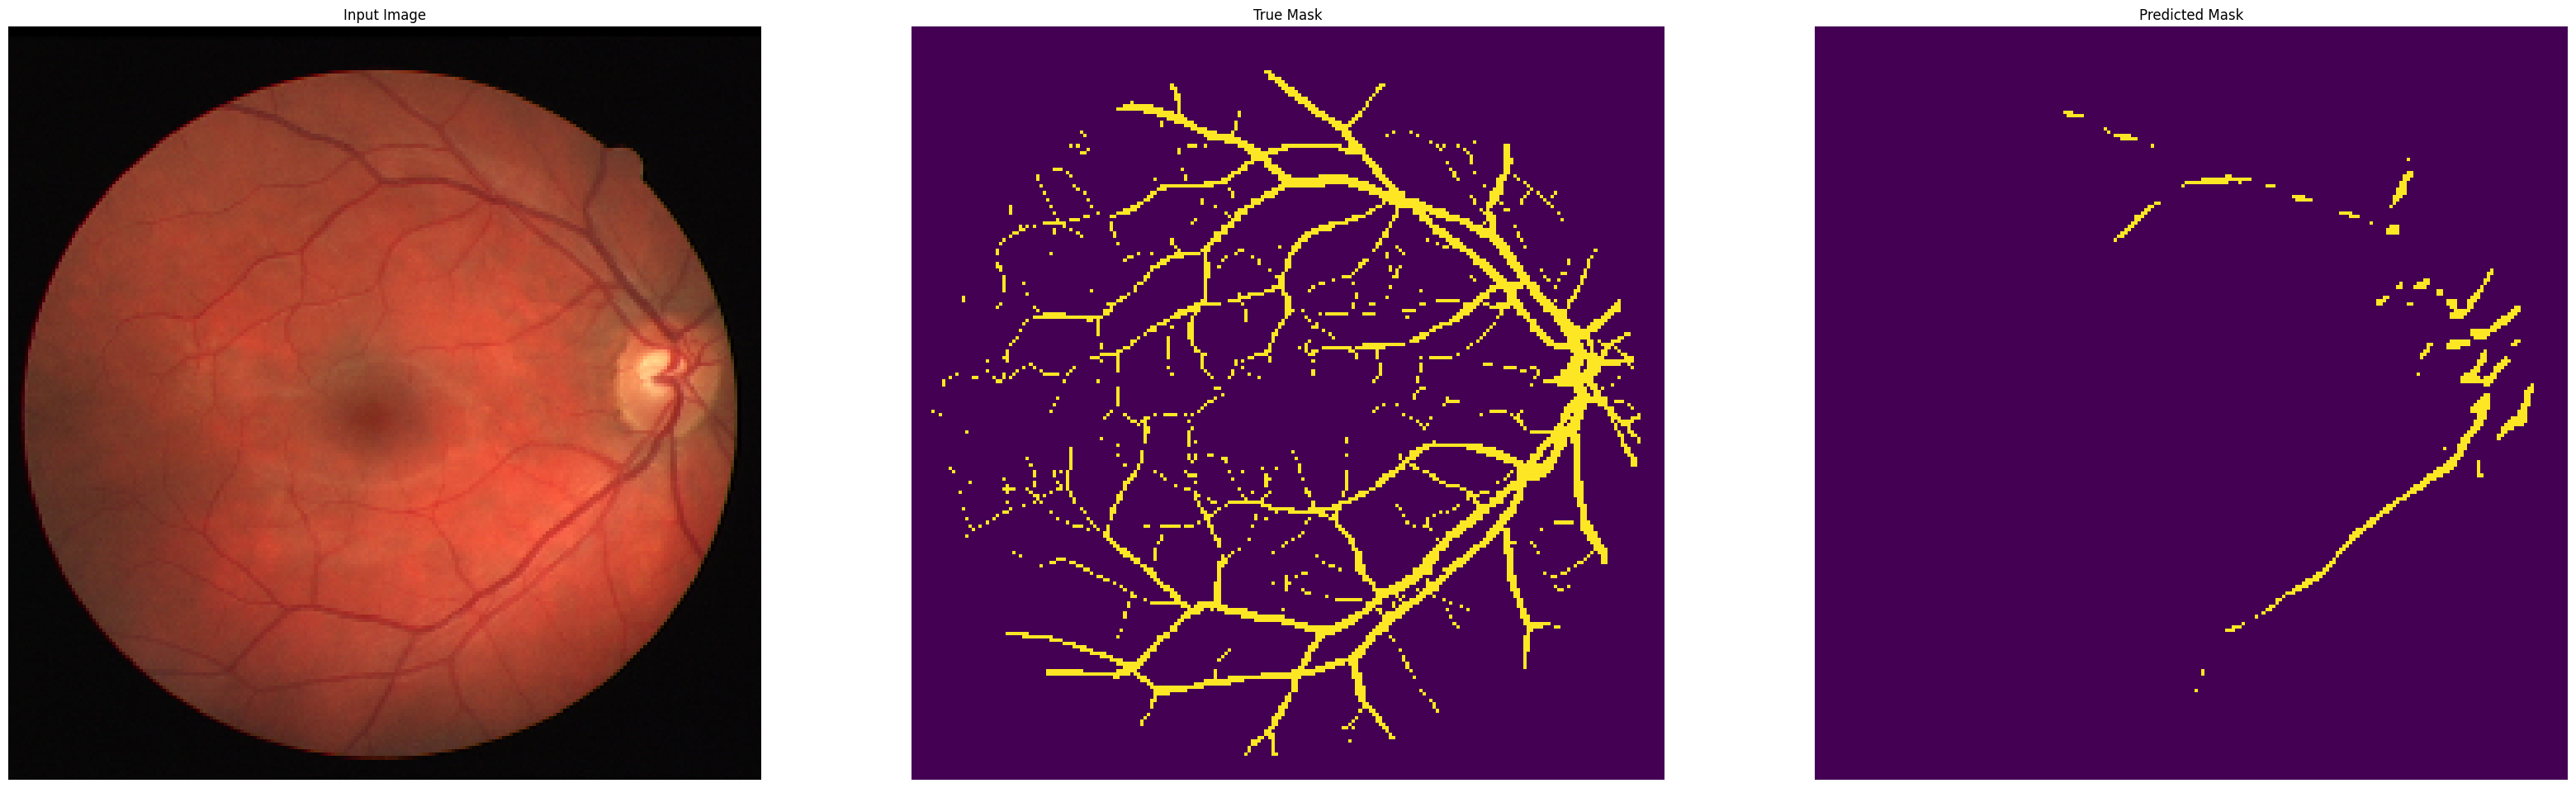

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
(224, 224, 1)


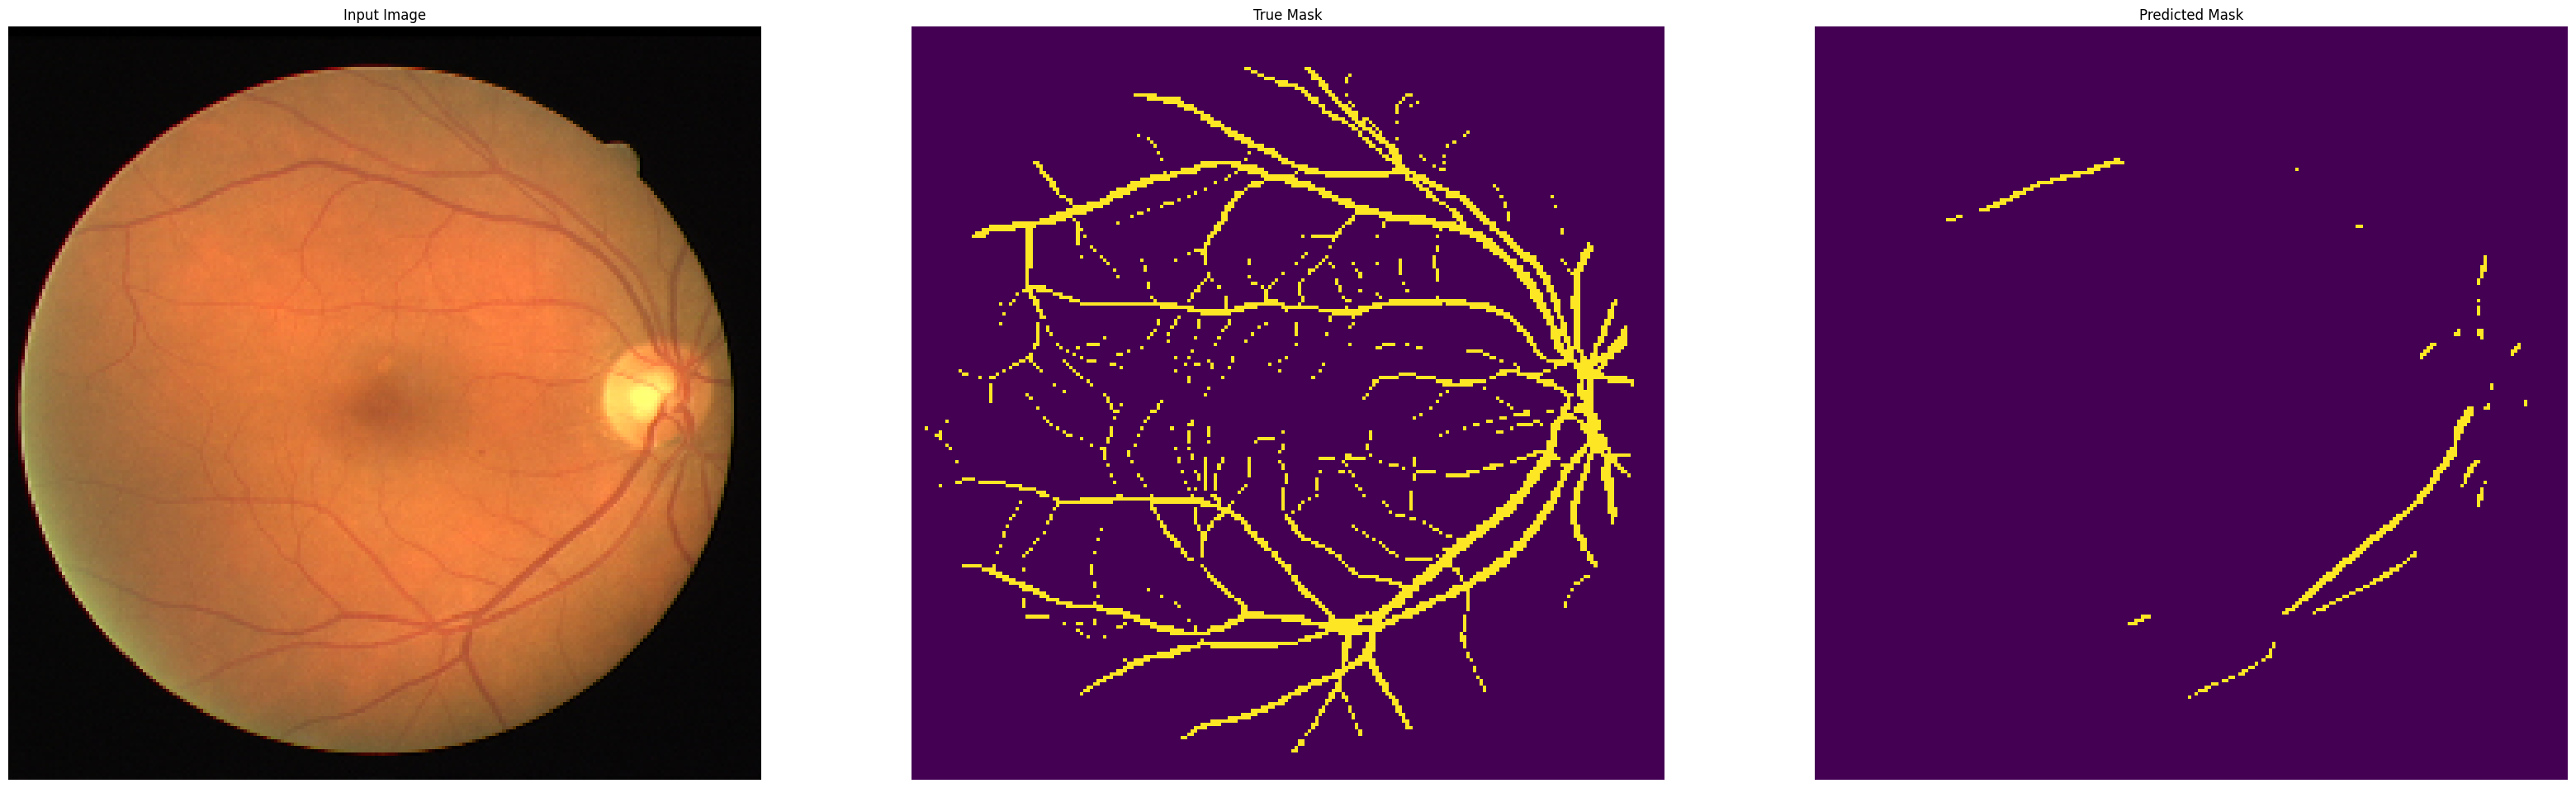

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
(224, 224, 1)


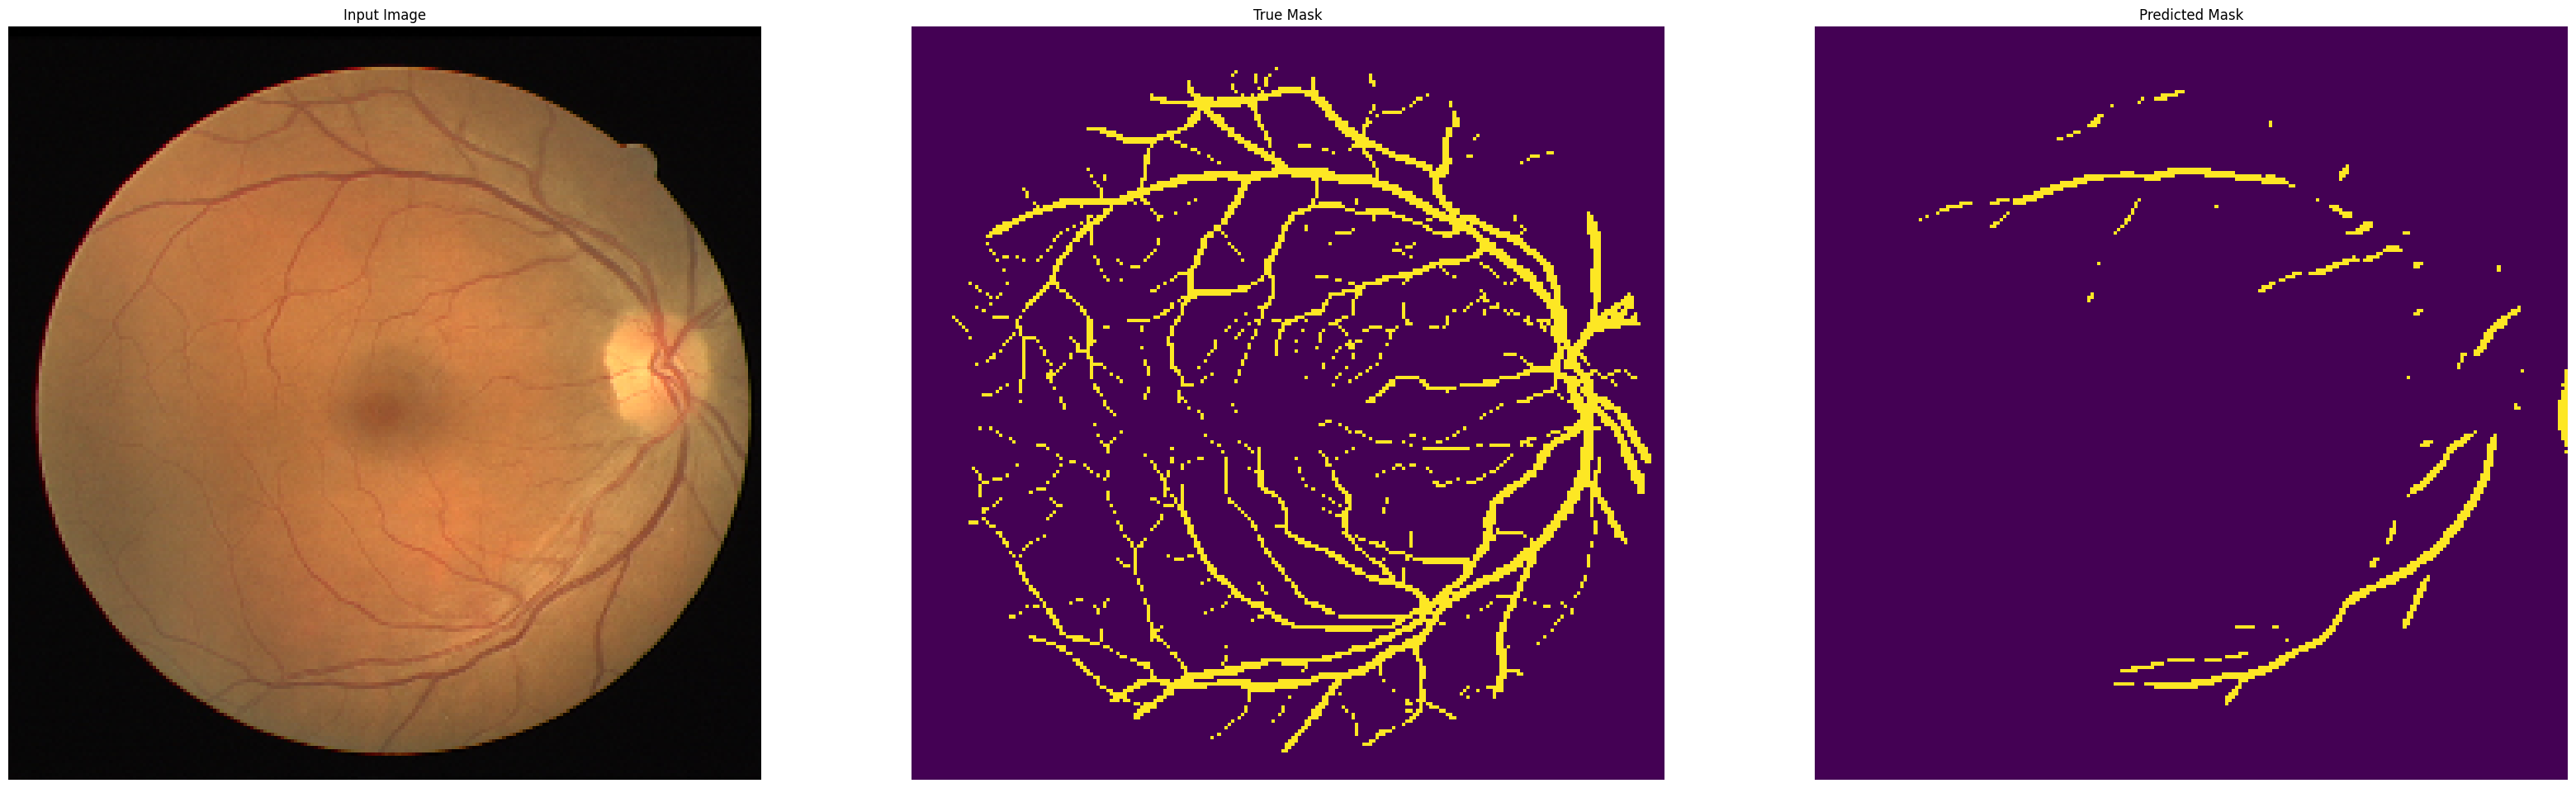

In [ ]:
show_predictions(dataset= train_dataset, num= 10)